In [ ]:
!pip install torch-geometric
!pip install --quiet torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install --quiet torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install --quiet torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install --quiet torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

In [ ]:
!unzip stanford-rna-3d-folding.zip

Archive:  stanford-rna-3d-folding.zip
  inflating: MSA/17RA_A.MSA.fasta    
  inflating: MSA/1A1T_B.MSA.fasta    
  inflating: MSA/1A4T_A.MSA.fasta    
  inflating: MSA/1A51_A.MSA.fasta    
  inflating: MSA/1A60_A.MSA.fasta    
  inflating: MSA/1A9N_Q.MSA.fasta    
  inflating: MSA/1AFX_A.MSA.fasta    
  inflating: MSA/1ANR_A.MSA.fasta    
  inflating: MSA/1AQO_A.MSA.fasta    
  inflating: MSA/1ATO_A.MSA.fasta    
  inflating: MSA/1ATV_A.MSA.fasta    
  inflating: MSA/1ATW_A.MSA.fasta    
  inflating: MSA/1AUD_B.MSA.fasta    
  inflating: MSA/1B36_A.MSA.fasta    
  inflating: MSA/1BAU_B.MSA.fasta    
  inflating: MSA/1BGZ_A.MSA.fasta    
  inflating: MSA/1BIV_A.MSA.fasta    
  inflating: MSA/1BVJ_A.MSA.fasta    
  inflating: MSA/1BZ2_A.MSA.fasta    
  inflating: MSA/1CQ5_A.MSA.fasta    
  inflating: MSA/1D0U_A.MSA.fasta    
  inflating: MSA/1D6K_B.MSA.fasta    
  inflating: MSA/1E4P_A.MSA.fasta    
  inflating: MSA/1E7K_D.MSA.fasta    
  inflating: MSA/1E95_A.MSA.fasta    
  inflating:

# Import Libraries

In [ ]:
import os
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import MessagePassing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch_geometric.data import Data, Batch
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.utils import to_dense_batch
from torch.utils.checkpoint import checkpoint

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

# Global Settings and Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_NUCLEOTIDES = 4 # A, C, G, U
MAX_SEQ_LENGTH = 500
EMBEDDING_DIM = 128
TRANSFORMER_DIM = 256
GNN_DIM = 256
HYBRID_DIM = 256
NUM_TRANSFORMER_LAYERS = 4
NUM_GNN_LAYERS = 4
NUM_HYBRID_LAYERS = 4
NUM_HEADS = 8
DROPOUT = 0.2
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 10
USE_ADVANCED_ROT_INV = False

Using device: cuda


# Helper functions for DataFrame processing

In [ ]:
def fix_columns(df, expected=['id', 'sequence']):
    if list(df.columns[:2]) != expected:
        df = df.rename(columns={df.columns[0]: 'id', df.columns[1]: 'sequence'})
    return df

def fix_labels(df):
    if 'id' not in df.columns:
        df = df.rename(columns={df.columns[0]: 'id'})
    return df

def move_batch_to_device(batch, device):
    new_batch = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            new_batch[k] = v.to(device)
        elif isinstance(v, list) and all(isinstance(x, torch.Tensor) for x in v):
            new_batch[k] = [x.to(device) for x in v]
        else:
            new_batch[k] = v
    return new_batch

def analyze_sequences(df):
    print("===== Training Sequences Analysis =====")
    print(f"Total sequences: {len(df)}")
    print(f"Available columns: {list(df.columns)}")
    lengths = df['sequence'].apply(len)
    print(f"Sequence length statistics: min={lengths.min()}, max={lengths.max()}, mean={lengths.mean():.2f}")

    """Count nucleotides"""
    all_nucleotides = "".join(df['sequence'].tolist())
    counter = Counter(all_nucleotides)
    total = sum(counter.get(nt, 0) for nt in "ACGU")
    print("Nucleotide distribution:")
    for nt in "ACGU":
        count = counter.get(nt, 0)
        percentage = (count / total * 100) if total > 0 else 0
        print(f"  {nt}: {count} ({percentage:.2f}%)")

    plt.figure(figsize=(8,6))
    plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of RNA Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.savefig("sequence_lengths_histogram.png")
    plt.close()
    print("Saved histogram plot to 'sequence_lengths_histogram.png'.")


# Contrastive Learning Components & Augmentations

In [ ]:
def random_sequence_masking(sample, mask_prob=0.1):
    seq = sample['sequence_onehot'].clone()
    mask = torch.rand(seq.shape[:2]) < mask_prob
    seq[mask] = 0
    sample['sequence_onehot'] = seq
    return sample

def get_contrastive_views(batch):
    batch_view1 = copy.deepcopy(batch)
    batch_view2 = copy.deepcopy(batch)
    seqs = batch_view2['sequence_onehot']
    for i in range(seqs.size(0)):
        sample = {'sequence_onehot': seqs[i]}
        aug_sample = random_sequence_masking(sample, mask_prob=0.1)
        seqs[i] = aug_sample['sequence_onehot']
    batch_view2['sequence_onehot'] = seqs
    return batch_view1, batch_view2

def contrastive_loss_fn(z_i, z_j, temperature=0.07):
    batch_size = z_i.size(0)
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)
    logits = torch.matmul(z_i, z_j.t()) / temperature
    labels = torch.arange(batch_size).long().to(z_i.device)
    loss = F.cross_entropy(logits, labels)
    return loss

# RNADataset and Collate Function

In [ ]:
class RNADataset(Dataset):
    def __init__(self, sequences_df, labels_df=None, max_length=MAX_SEQ_LENGTH, transform=None):
        self.sequences = sequences_df
        self.labels = labels_df
        self.max_length = max_length
        self.transform = transform
        self.nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'U': 3, 'N': 4}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if 'id' not in self.sequences.columns or 'sequence' not in self.sequences.columns:
            raise KeyError("Columns 'id' and 'sequence' expected.")
        seq_id = self.sequences.iloc[idx]['id']
        sequence = self.sequences.iloc[idx]['sequence']
        seq_numeric = [self.nucleotide_map.get(nt, 4) for nt in sequence[:self.max_length]]
        seq_length = len(seq_numeric)
        if seq_length < self.max_length:
            seq_numeric += [4] * (self.max_length - seq_length)
        seq_onehot = np.zeros((self.max_length, 5), dtype=np.float32)
        for i, nt in enumerate(seq_numeric):
            seq_onehot[i, nt] = 1.0
        edge_index, edge_attr = self._create_graph(sequence)
        sample = {
            'id': seq_id,
            'sequence': torch.tensor(seq_numeric, dtype=torch.long),
            'sequence_onehot': torch.tensor(seq_onehot, dtype=torch.float),
            'length': seq_length,
            'edge_index': edge_index,
            'edge_attr': edge_attr
        }
        if self.labels is not None:
            matching_rows = self.labels[self.labels['id'] == seq_id]
            if matching_rows.empty:
                coords = [[0, 0, 0]] * self.max_length
            else:
                label_row = matching_rows.iloc[0]
                x_val = label_row.get("x_1", 0)
                y_val = label_row.get("y_1", 0)
                z_val = label_row.get("z_1", 0)
                base = np.array([x_val, y_val, z_val], dtype=np.float32)
                amplitude = 0.5
                idxs = np.linspace(0, np.pi, seq_length).reshape(-1, 1)
                variation = amplitude * np.concatenate([np.sin(idxs), np.cos(idxs), np.sin(idxs/2)], axis=1)
                coords = (base + variation).tolist()
                if seq_length < self.max_length:
                    coords.extend([[0, 0, 0]] * (self.max_length - seq_length))
            sample['coordinates'] = torch.tensor(coords, dtype=torch.float)
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _create_graph(self, sequence):
        seq_length = min(len(sequence), self.max_length)
        edges = []
        edge_features = []

        for i in range(seq_length - 1):
            edges.append([i, i+1])
            edges.append([i+1, i])
            edge_features.append([1, 0, 0])
            edge_features.append([1, 0, 0])

        for i in range(seq_length):
            for j in range(i+4, seq_length):
                if (sequence[i] == 'A' and sequence[j] == 'U') or \
                   (sequence[i] == 'U' and sequence[j] == 'A') or \
                   (sequence[i] == 'G' and sequence[j] == 'C') or \
                   (sequence[i] == 'C' and sequence[j] == 'G'):
                    edges.append([i, j])
                    edges.append([j, i])
                    edge_features.append([0, 1, 0])
                    edge_features.append([0, 1, 0])

        for i in range(seq_length):
            edges.append([i, i])
            edge_features.append([0, 0, 1])
        if not edges:
            edges.append([0, 0])
            edge_features.append([0, 0, 1])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
        return edge_index, edge_attr

def collate_rna_data(batch):
    ids = [item['id'] for item in batch]
    sequences = torch.stack([item['sequence'] for item in batch])
    sequence_onehots = torch.stack([item['sequence_onehot'] for item in batch])
    lengths = torch.tensor([item['length'] for item in batch])
    edge_indices = [item['edge_index'] for item in batch]
    edge_attrs = [item['edge_attr'] for item in batch]
    batch_dict = {
        'id': ids,
        'sequence': sequences,
        'sequence_onehot': sequence_onehots,
        'length': lengths,
        'edge_index': edge_indices,
        'edge_attr': edge_attrs
    }
    if 'coordinates' in batch[0]:
        coords = torch.stack([item['coordinates'] for item in batch])
        batch_dict['coordinates'] = coords
    return batch_dict

# Model Components: Hybrid Graph-Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_SEQ_LENGTH):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        if mask is not None:
            out = self.transformer_encoder(x, src_key_padding_mask=mask)
        else:
            out = self.transformer_encoder(x)
        return out

class GNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNNLayer, self).__init__(aggr='add')
        self.lin_node = nn.Linear(in_channels, out_channels)
        self.lin_edge = nn.Linear(3, out_channels)
        self.lin_update = nn.Linear(2 * out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin_node(x)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        edge_embedding = self.lin_edge(edge_attr)
        return x_j * edge_embedding

    def update(self, aggr_out, x):
        combined = torch.cat([aggr_out, x], dim=1)
        return F.relu(self.lin_update(combined))

class GNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GNNEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.gnn_layers = nn.ModuleList([GNNLayer(hidden_dim, hidden_dim) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_attr):
        x = self.embedding(x)
        for layer in self.gnn_layers:
            x = layer(x, edge_index, edge_attr)
        return x

class RotationallyInvariantEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RotationallyInvariantEmbedding, self).__init__()
        self.transform = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.transform(x)

"""Advanced Rotational Invariance (Placeholder using a similar architecture)"""
class AdvancedRotInvariant(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedRotInvariant, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
    def forward(self, x):
        return self.block(x)

def get_rotational_invariant_module(input_dim, output_dim):
    if USE_ADVANCED_ROT_INV:
        return AdvancedRotInvariant(input_dim, output_dim)
    else:
        return RotationallyInvariantEmbedding(input_dim, output_dim)

class HybridLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout):
        super(HybridLayer, self).__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.gnn_layer = GNNLayer(hidden_dim, hidden_dim)
        self.integration = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, x_transformer, x_gnn, edge_index_list, edge_attr_list, mask=None):
        if mask is not None:
            x_transformer_new = self.transformer_layer(x_transformer, src_key_padding_mask=mask)
        else:
            x_transformer_new = self.transformer_layer(x_transformer)
        batch_size = x_gnn.size(0)
        gnn_new_list = []
        for i in range(batch_size):
            e_index = edge_index_list[i].to(x_gnn.device)
            e_attr = edge_attr_list[i].to(x_gnn.device)
            gnn_new = self.gnn_layer(x_gnn[i], e_index, e_attr)
            gnn_new_list.append(gnn_new)
        x_gnn_new = torch.stack(gnn_new_list, dim=0)
        x_combined = torch.cat([x_transformer_new, x_gnn_new], dim=-1)
        x_integrated = F.relu(self.integration(x_combined))
        return x_integrated, x_transformer_new, x_gnn_new

class RNAFoldNet(nn.Module):
    def __init__(self,
                 input_dim=5,
                 transformer_dim=TRANSFORMER_DIM,
                 gnn_dim=GNN_DIM,
                 hybrid_dim=HYBRID_DIM,
                 num_transformer_layers=NUM_TRANSFORMER_LAYERS,
                 num_gnn_layers=NUM_GNN_LAYERS,
                 num_hybrid_layers=NUM_HYBRID_LAYERS,
                 num_heads=NUM_HEADS,
                 dropout=DROPOUT):
        super(RNAFoldNet, self).__init__()
        self.transformer_encoder = TransformerEncoder(input_dim, transformer_dim, num_transformer_layers, num_heads, dropout)
        self.gnn_encoder = GNNEncoder(input_dim, gnn_dim, num_gnn_layers)
        self.hybrid_layers = nn.ModuleList([
            HybridLayer(hybrid_dim, num_heads, dropout) for _ in range(num_hybrid_layers)
        ])
        self.project_transformer = nn.Linear(transformer_dim, hybrid_dim)
        self.project_gnn = nn.Linear(gnn_dim, hybrid_dim)
        self.rot_invariant = get_rotational_invariant_module(hybrid_dim, hybrid_dim)
        self.output_layer = nn.Sequential(
            nn.Linear(hybrid_dim, hybrid_dim),
            nn.ReLU(),
            nn.Linear(hybrid_dim, 3)
        )

    def forward(self, batch):
        seq_onehot = batch['sequence_onehot']  # (B, L, 5)
        edge_index_list = batch['edge_index']
        edge_attr_list = batch['edge_attr']
        padding_mask = (batch['sequence'] == 4)

        transformer_features = self.transformer_encoder(seq_onehot, padding_mask)
        batch_size, seq_len, _ = seq_onehot.shape
        gnn_features = []
        for i in range(batch_size):
            seq_i = seq_onehot[i]
            e_index = edge_index_list[i].to(device)
            e_attr = edge_attr_list[i].to(device)
            gnn_out = self.gnn_encoder(seq_i, e_index, e_attr)
            gnn_features.append(gnn_out)
        gnn_features = torch.stack(gnn_features)
        transformer_proj = self.project_transformer(transformer_features)
        x_hybrid = transformer_proj
        x_transformer = transformer_features
        x_gnn = gnn_features
        for layer in self.hybrid_layers:
            x_hybrid, x_transformer, x_gnn = layer(
                x_transformer=x_hybrid,
                x_gnn=x_hybrid,
                edge_index_list=edge_index_list,
                edge_attr_list=edge_attr_list,
                mask=padding_mask
            )
        x_invariant = self.rot_invariant(x_hybrid)
        coords_pred = self.output_layer(x_invariant)
        return coords_pred

# Contrastive RNAFoldNet Wrapper

In [ ]:
class ContrastiveRNAFoldNet(nn.Module):
    def __init__(self, base_model: 'RNAFoldNet', pool='mean'):
        super().__init__()
        self.base_model = base_model
        self.pool = pool
        self.projection_head = nn.Sequential(
            nn.Linear(HYBRID_DIM, HYBRID_DIM),
            nn.ReLU(),
            nn.Linear(HYBRID_DIM, 128)
        )

    def forward(self, batch):
        with torch.no_grad():
            seq_onehot = batch['sequence_onehot']
            edge_index_list = batch['edge_index']
            edge_attr_list = batch['edge_attr']
            padding_mask = (batch['sequence'] == 4)

            transformer_features = self.base_model.transformer_encoder(seq_onehot, padding_mask)
            batch_size, seq_len, _ = seq_onehot.shape

            gnn_features = []
            for i in range(batch_size):
                seq_i = seq_onehot[i]
                e_index = edge_index_list[i].to(device)
                e_attr = edge_attr_list[i].to(device)
                gnn_out = self.base_model.gnn_encoder(seq_i, e_index, e_attr)
                gnn_features.append(gnn_out)
            gnn_features = torch.stack(gnn_features)

            transformer_proj = self.base_model.project_transformer(transformer_features)
            x_hybrid = transformer_proj
            for layer in self.base_model.hybrid_layers:
                x_hybrid, _, _ = layer(
                    x_transformer=x_hybrid,
                    x_gnn=x_hybrid,
                    edge_index_list=edge_index_list,
                    edge_attr_list=edge_attr_list,
                    mask=padding_mask
                )
            x_invariant = self.base_model.rot_invariant(x_hybrid)

        if self.pool == 'mean':
            embedding = x_invariant.mean(dim=1)
        else:
            embedding = x_invariant.mean(dim=1)

        embedding = self.projection_head(embedding)
        return embedding

def contrastive_pretraining(contrastive_model, train_loader, num_epochs=5, lr=1e-4):
    optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        steps = 0
        for batch in tqdm(train_loader, desc=f"Contrastive Epoch {epoch+1}/{num_epochs}"):
            batch = move_batch_to_device(batch, device)
            view1, view2 = get_contrastive_views(batch)
            z_i = contrastive_model(view1)
            z_j = contrastive_model(view2)
            loss = contrastive_loss_fn(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            steps += 1
        print(f"Contrastive Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/steps:.4f}")
    print("Contrastive pretraining complete!")

def visualize_contrastive_embeddings(contrastive_model, loader, num_samples=200):
    contrastive_model.eval()
    embeddings = []
    labels = []
    count = 0
    with torch.no_grad():
        for batch in loader:
            batch = move_batch_to_device(batch, device)
            z = contrastive_model(batch).cpu().numpy()
            embeddings.append(z)
            labels += batch['id']
            count += z.shape[0]
            if count >= num_samples:
                break
    embeddings = np.concatenate(embeddings, axis=0)
    if embeddings.shape[0] > num_samples:
        embeddings = embeddings[:num_samples]
        labels = labels[:num_samples]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.7, edgecolors='k')
    plt.title("t-SNE of Contrastive Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.savefig("contrastive_tsne.png")
    plt.close()
    print("Saved t-SNE plot to 'contrastive_tsne.png'.")

# Supervised Training Helpers

In [ ]:
def rmsd_loss(pred, target, lengths):
    batch_size = pred.size(0)
    total_loss = 0
    for i in range(batch_size):
        length = lengths[i]
        p = pred[i, :length]
        t = target[i, :length]
        p_centered = p - p.mean(dim=0, keepdim=True)
        t_centered = t - t.mean(dim=0, keepdim=True)
        rmsd = torch.sqrt(((p_centered - t_centered) ** 2).sum(-1).mean())
        total_loss += rmsd
    return total_loss / batch_size

def train_model(model, train_loader, val_loader, num_epochs, learning_rate):

    """Using weight_decay to add L2 regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    """Using CosineAnnealingLR for smoother learning rate scheduling"""
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = 3

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        steps = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            batch = move_batch_to_device(batch, device)
            pred_coords = model(batch)
            loss = rmsd_loss(pred_coords, batch['coordinates'], batch['length'])
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            steps += 1
        avg_train_loss = train_loss / steps
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        steps = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                batch = move_batch_to_device(batch, device)
                pred_coords = model(batch)
                loss = rmsd_loss(pred_coords, batch['coordinates'], batch['length'])
                val_loss += loss.item()
                steps += 1
        avg_val_loss = val_loss / steps
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        scheduler.step()


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses

def predict(model, test_loader):
    model.eval()
    predictions = {}
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating predictions"):
            batch = move_batch_to_device(batch, device)
            pred_coords = model(batch)
            for i, seq_id in enumerate(batch['id']):
                length = batch['length'][i]
                coords = pred_coords[i, :length].cpu().numpy()
                predictions[seq_id] = coords
    return predictions

def create_submission(predictions, output_file='submission.csv'):
    max_length = max(coords.shape[0] for coords in predictions.values())
    padded_predictions = {}
    for seq_id, coords in predictions.items():
        if coords.shape[0] < max_length:
            pad_width = max_length - coords.shape[0]
            coords = np.pad(coords, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
        padded_predictions[seq_id] = coords

    ids = list(padded_predictions.keys())
    data = {'id': ids}
    for i in range(max_length):
        xs, ys, zs = [], [], []
        for seq_id in ids:
            coords = padded_predictions[seq_id]
            xs.append(coords[i, 0])
            ys.append(coords[i, 1])
            zs.append(coords[i, 2])
        data[f'x_{i}'] = xs
        data[f'y_{i}'] = ys
        data[f'z_{i}'] = zs

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

def analyze_labels(df):
    print("===== Training Labels Analysis =====")
    print(f"Total label entries: {len(df)}")
    print(f"Available columns: {list(df.columns)}")
    coord_cols = [col for col in df.columns if col.startswith("x_") or col.startswith("y_") or col.startswith("z_")]
    print(f"Coordinate columns found: {len(coord_cols)//3} sets of coordinates")
    if coord_cols:
        for axis in ['x', 'y', 'z']:
            col = f'{axis}_1'
            if col in df.columns:
                mean_val = df[col].mean()
                std_val = df[col].std()
                print(f"{axis.upper()} - Mean: {mean_val:.2f}, Std: {std_val:.2f}")

def check_duplicates(df):
    print("Verifying duplicates in training sequences...")
    duplicates = df.duplicated(subset=['sequence'])
    if duplicates.any():
        print(f"Found {duplicates.sum()} duplicates.")
    else:
        print("No duplicates found.")

def create_submission_template(sample_submission_file):
    try:
        submission_df = pd.read_csv(sample_submission_file)
        print("===== Submission Template =====")
        print(f"Template shape: {submission_df.shape}")
        print("First 5 rows:")
        print(submission_df.head())
    except Exception as e:
        print(f"Could not load submission template: {e}")

# Main Function

In [ ]:
def main():
    start_time = time.time()
    print("Loading main data...")
    train_seq_df = pd.read_csv('train_sequences.csv')
    train_labels_df = pd.read_csv('train_labels.csv')
    val_seq_df = pd.read_csv('validation_sequences.csv')
    val_labels_df = pd.read_csv('validation_labels.csv')
    test_seq_df = pd.read_csv('test_sequences.csv')

    try:
        sample_sub_df = pd.read_csv('sample_submission.csv')
        print("Sample submission loaded, shape:", sample_sub_df.shape)
    except Exception as e:
        print("Sample submission file not found or error:", e)

    print("Files loaded:")
    print(f"Train sequences: {train_seq_df.shape}")
    print(f"Train labels: {train_labels_df.shape}")
    print(f"Validation sequences: {val_seq_df.shape}")
    print(f"Validation labels: {val_labels_df.shape}")
    print(f"Test sequences: {test_seq_df.shape}")


    train_seq_df = fix_columns(train_seq_df)
    val_seq_df = fix_columns(val_seq_df)
    test_seq_df = fix_columns(test_seq_df)
    train_labels_df = fix_labels(train_labels_df)
    val_labels_df = fix_labels(val_labels_df)

    initial_train_count = len(train_seq_df)
    train_seq_df = train_seq_df.drop_duplicates(subset=['sequence'])
    print(f"Removed {initial_train_count - len(train_seq_df)} duplicate training sequences.")

    analyze_sequences(train_seq_df)
    analyze_labels(train_labels_df)
    check_duplicates(train_seq_df)
    if os.path.exists('sample_submission.csv'):
        create_submission_template('sample_submission.csv')

    print("Creating datasets and dataloaders...")
    train_dataset = RNADataset(train_seq_df, train_labels_df)
    val_dataset = RNADataset(val_seq_df, val_labels_df)
    test_dataset = RNADataset(test_seq_df)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, collate_fn=collate_rna_data)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, collate_fn=collate_rna_data)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=2, collate_fn=collate_rna_data)


    """Contrastive Pretraining"""

    print("Initializing base RNAFoldNet for contrastive pretraining...")
    base_model = RNAFoldNet().to(device)
    contrastive_model = ContrastiveRNAFoldNet(base_model).to(device)
    print("Starting contrastive pretraining...")
    contrastive_pretraining(contrastive_model, train_loader, num_epochs=10, lr=1e-4)
    print("Visualizing contrastive embeddings...")
    visualize_contrastive_embeddings(contrastive_model, train_loader, num_samples=200)


    """Supervised Training"""

    print("Initializing RNAFoldNet for supervised training...")
    model = RNAFoldNet().to(device)


    print("Training RNAFoldNet for structure prediction...")
    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                           num_epochs=NUM_EPOCHS,
                                           learning_rate=LEARNING_RATE)
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("RMSD Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig("training_curve.png")
    plt.close()
    print("Training curve saved as 'training_curve.png'.")


    model.load_state_dict(torch.load('best_model.pt'))

    print("Generating predictions on test set...")
    test_predictions = predict(model, test_loader)
    print("Creating submission file...")
    create_submission(test_predictions, output_file='submission.csv')

    runtime = time.time() - start_time
    print(f"Runtime: {runtime:.2f} seconds")
    print("Model training complete! Results saved to CSV files.")

if __name__ == "__main__":
    main()


Loading main data...
Sample submission loaded, shape: (2515, 18)
Files loaded:
Train sequences: (844, 5)
Train labels: (137095, 6)
Validation sequences: (12, 5)
Validation labels: (2515, 123)
Test sequences: (12, 5)
Removed 60 duplicate training sequences.
===== Training Sequences Analysis =====
Total sequences: 784
Available columns: ['id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']
Sequence length statistics: min=3, max=4298, mean=168.24
Nucleotide distribution:
  A: 31198 (23.65%)
  C: 32774 (24.85%)
  G: 40104 (30.41%)
  U: 27816 (21.09%)
Saved histogram plot to 'sequence_lengths_histogram.png'.
===== Training Labels Analysis =====
Total label entries: 137095
Available columns: ['id', 'resname', 'resid', 'x_1', 'y_1', 'z_1']
Coordinate columns found: 1 sets of coordinates
X - Mean: 80.45, Std: 147.42
Y - Mean: 84.04, Std: 114.93
Z - Mean: 98.61, Std: 119.41
Verifying duplicates in training sequences...
No duplicates found.
===== Submission Template =====
Templat

Contrastive Epoch 1/10: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s]


Contrastive Epoch 1/10 - Loss: 1.3517


Contrastive Epoch 2/10: 100%|██████████| 49/49 [00:26<00:00,  1.82it/s]


Contrastive Epoch 2/10 - Loss: 0.7845


Contrastive Epoch 3/10: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s]


Contrastive Epoch 3/10 - Loss: 0.6384


Contrastive Epoch 4/10: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s]


Contrastive Epoch 4/10 - Loss: 0.5468


Contrastive Epoch 5/10: 100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


Contrastive Epoch 5/10 - Loss: 0.4857


Contrastive Epoch 6/10: 100%|██████████| 49/49 [00:26<00:00,  1.88it/s]


Contrastive Epoch 6/10 - Loss: 0.4907


Contrastive Epoch 7/10: 100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


Contrastive Epoch 7/10 - Loss: 0.4195


Contrastive Epoch 8/10: 100%|██████████| 49/49 [00:26<00:00,  1.84it/s]


Contrastive Epoch 8/10 - Loss: 0.4242


Contrastive Epoch 9/10: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s]


Contrastive Epoch 9/10 - Loss: 0.4446


Contrastive Epoch 10/10: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s]

Contrastive Epoch 10/10 - Loss: 0.4202
Contrastive pretraining complete!
Visualizing contrastive embeddings...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Saved t-SNE plot to 'contrastive_tsne.png'.
Initializing RNAFoldNet for supervised training...
Training RNAFoldNet for structure prediction...


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 1/10 - Train Loss: 0.0949, Val Loss: 0.0812
Saved best model with Val Loss: 0.0812


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch 2/10 - Train Loss: 0.0428, Val Loss: 0.0374
Saved best model with Val Loss: 0.0374


Epoch 3/10 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Epoch 3/10 - Train Loss: 0.0326, Val Loss: 0.0648


Epoch 4/10 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 4/10 - Train Loss: 0.0365, Val Loss: 0.0526


Epoch 5/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 5/10 - Train Loss: 0.0173, Val Loss: 0.0354
Saved best model with Val Loss: 0.0354


Epoch 6/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 6/10 - Train Loss: 0.0124, Val Loss: 0.0132
Saved best model with Val Loss: 0.0132


Epoch 7/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 7/10 - Train Loss: 0.0063, Val Loss: 0.0133


Epoch 8/10 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Epoch 8/10 - Train Loss: 0.0044, Val Loss: 0.0083
Saved best model with Val Loss: 0.0083


Epoch 9/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Epoch 9/10 - Train Loss: 0.0023, Val Loss: 0.0042
Saved best model with Val Loss: 0.0042


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 10/10 - Train Loss: 0.0012, Val Loss: 0.0021
Saved best model with Val Loss: 0.0021


<ipython-input-11-812410fa7bf9>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Training curve saved as 'training_curve.png'.
Generating predictions on test set...


Generating predictions: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

Creating submission file...
Submission saved to submission.csv
Runtime: 575.01 seconds
Model training complete! Results saved to CSV files.


# Energy-Guided Refinement via Diffusion Models

In [ ]:
print("GPU Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

train_seqs = pd.read_csv(os.path.join("train_sequences.csv"))
train_labels = pd.read_csv(os.path.join("train_labels.csv"))

print("Train sequences shape:", train_seqs.shape)
print("Train labels shape:", train_labels.shape)

"""Nucleotide mapping for one-hot encoding"""
nt_map = {'A': 0, 'C': 1, 'G': 2, 'U': 3}

class RNAGraphData:
    def __init__(self, graph, mean, std):
        self.graph = graph
        self.mean = mean
        self.std = std

def create_rna_graph(seq, coords):
    """
    Convert an RNA sequence and its 3D coordinates into a graph.
    - Nodes: One-hot nucleotide
    - Edges: Linear backbone (bidirectional)
    - Target: 3D coords per nucleotide (normalized)
    """
    x = torch.eye(4)[[nt_map[n] for n in seq]]

    edge_index = []
    for i in range(len(seq) - 1):
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).T


    coords_mean = np.mean(coords, axis=0)
    coords_std = np.std(coords, axis=0)
    coords_normalized = (coords - coords_mean) / coords_std
    y = torch.tensor(coords_normalized, dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, y=y)
    return RNAGraphData(graph, coords_mean, coords_std)

def denormalize_coords(coords, mean, std):
    """
    Denormalize coordinates back to their original scale.
    """
    if torch.is_tensor(coords):
        mean_tensor = torch.tensor(mean, device=coords.device)
        std_tensor = torch.tensor(std, device=coords.device)
        return coords * std_tensor + mean_tensor
    else:
        return coords * std + mean

def find_valid_sample(train_seqs, train_labels):
    for i in range(len(train_seqs)):
        row = train_seqs.iloc[i]
        rna_id = row['target_id']
        seq = row['sequence']
        matching = train_labels[train_labels['ID'].str.startswith(rna_id)]
        coords = matching[['x_1', 'y_1', 'z_1']].astype(float).values
        if len(coords) == len(seq):
            print(f"Found valid sample at index {i}: {rna_id}")
            return seq, coords
    print("No valid sample found.")
    return None, None


seq, coords = find_valid_sample(train_seqs, train_labels)
rna_data = create_rna_graph(seq, coords) if seq is not None and coords is not None else None
print(rna_data.graph if rna_data else None)

"""Pre-filter valid IDs"""
valid_ids = []
for i in range(len(train_seqs)):
    row = train_seqs.iloc[i]
    rna_id = row['target_id']
    seq = row['sequence']
    matching = train_labels[train_labels['ID'].str.startswith(rna_id)]
    coords = matching[['x_1', 'y_1', 'z_1']].astype(float).values
    if len(coords) != len(seq):
        continue
    std = np.std(coords, axis=0)
    if np.any(std == 0) or np.isnan(coords).any() or np.isinf(coords).any():
        continue
    valid_ids.append(rna_id)

GPU Available: True
Device: Tesla T4
Train sequences shape: (844, 5)
Train labels shape: (137095, 6)
Found valid sample at index 0: 1SCL_A
Data(x=[29, 4], edge_index=[2, 56], y=[29, 3])


# Dataset class for RNAGraphData

In [ ]:
class RNADataset(torch.utils.data.Dataset):
    def __init__(self, seq_df, label_df, transform=None):
        super().__init__()
        self.seq_df = seq_df
        self.label_df = label_df
        self.transform = transform
        self.valid_ids = valid_ids
        self.data_list = []
        for idx in range(len(self.seq_df)):
            row = self.seq_df.iloc[idx]
            rna_id = row['target_id']
            if rna_id not in self.valid_ids:
                continue
            seq = row['sequence']
            matching = self.label_df[self.label_df['ID'].str.startswith(rna_id)]
            coords = matching[['x_1', 'y_1', 'z_1']].astype(float).values
            try:
                rna_data = create_rna_graph(seq, coords)
                if self.transform:
                    rna_data.graph = self.transform(rna_data.graph)
                self.data_list.append(rna_data)
            except Exception:
                continue

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


dataset = RNADataset(train_seqs, train_labels)
print(f"Valid graphs: {len(dataset)}")
split = int(0.9 * len(dataset))
train_data = dataset.data_list[:split]
val_data = dataset.data_list[split:]

"""Custom collate for PyG Data objects"""
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    graphs = [item.graph for item in batch]
    means = [item.mean for item in batch]
    stds = [item.std for item in batch]
    batched_graphs = Batch.from_data_list(graphs)
    return batched_graphs, means, stds

train_loader = TorchDataLoader(train_data, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader = TorchDataLoader(val_data, batch_size=4, collate_fn=custom_collate)

Valid graphs: 606


# Graph Transformer model

In [ ]:
class GraphTransformer(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=128, max_len=5000):
        super().__init__()
        self.embedding = nn.Linear(in_dim, hidden_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=hidden_dim, nhead=8, dim_feedforward=256, dropout=0.1, batch_first=True
        )
        self.encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.output = nn.Linear(hidden_dim, 3)
        self.position_embeddings = nn.Embedding(max_len, hidden_dim)

    def _encoder_forward(self, x):
        return self.encoder(x)

    def forward(self, x, batch=None):
        if batch is not None:
            x, mask = to_dense_batch(x, batch)
            x = self.embedding(x)
            position_ids = torch.arange(x.size(1), device=x.device).unsqueeze(0)
            position_embeddings = self.position_embeddings(position_ids)
            x = x + position_embeddings
            x = checkpoint(self._encoder_forward, x)
            out = self.output(x)
            return out, mask
        else:
            x = self.embedding(x)
            position_ids = torch.arange(x.size(0), device=x.device).unsqueeze(0)
            position_embeddings = self.position_embeddings(position_ids)
            x = x + position_embeddings.squeeze(0)
            x = self.encoder(x.unsqueeze(0))
            coords = self.output(x.squeeze(0))
            return coords

# --- Diffusion Refiner training--- with --- Testing and Plotting ---

Training Diffusion Refiner...
Epoch 1 | Diffusion Loss: 0.6222
Epoch 2 | Diffusion Loss: 0.5751
Epoch 3 | Diffusion Loss: 0.5581
Epoch 4 | Diffusion Loss: 0.5467
Epoch 5 | Diffusion Loss: 0.5309
Epoch 6 | Diffusion Loss: 0.5338
Epoch 7 | Diffusion Loss: 0.5313
Epoch 8 | Diffusion Loss: 0.5195
Epoch 9 | Diffusion Loss: 0.5220
Epoch 10 | Diffusion Loss: 0.5078
Epoch 11 | Diffusion Loss: 0.5253
Epoch 12 | Diffusion Loss: 0.5006
Epoch 13 | Diffusion Loss: 0.5157
Epoch 14 | Diffusion Loss: 0.4942
Epoch 15 | Diffusion Loss: 0.5165
Epoch 16 | Diffusion Loss: 0.5096
Epoch 17 | Diffusion Loss: 0.5169
Epoch 18 | Diffusion Loss: 0.5018
Epoch 19 | Diffusion Loss: 0.5032
Epoch 20 | Diffusion Loss: 0.5119
Epoch 21 | Diffusion Loss: 0.5100
Epoch 22 | Diffusion Loss: 0.5108
Epoch 23 | Diffusion Loss: 0.5033
Epoch 24 | Diffusion Loss: 0.5124
Epoch 25 | Diffusion Loss: 0.5033
Epoch 26 | Diffusion Loss: 0.5081
Epoch 27 | Diffusion Loss: 0.5099
Epoch 28 | Diffusion Loss: 0.5035
Epoch 29 | Diffusion Loss: 

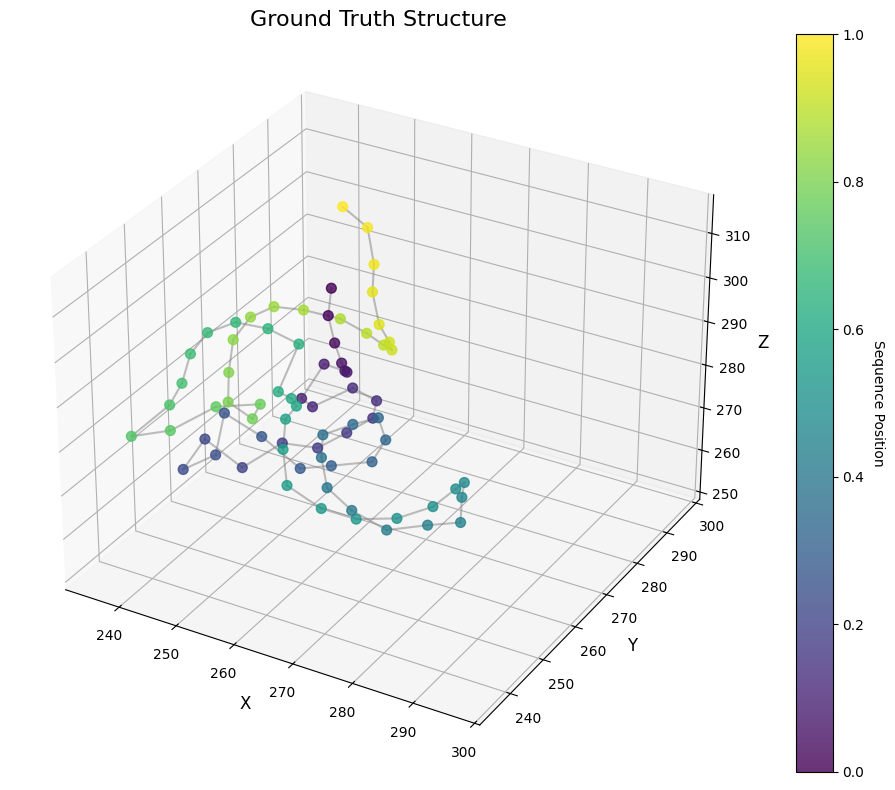

Coarse Prediction Structure - Number of points: 75


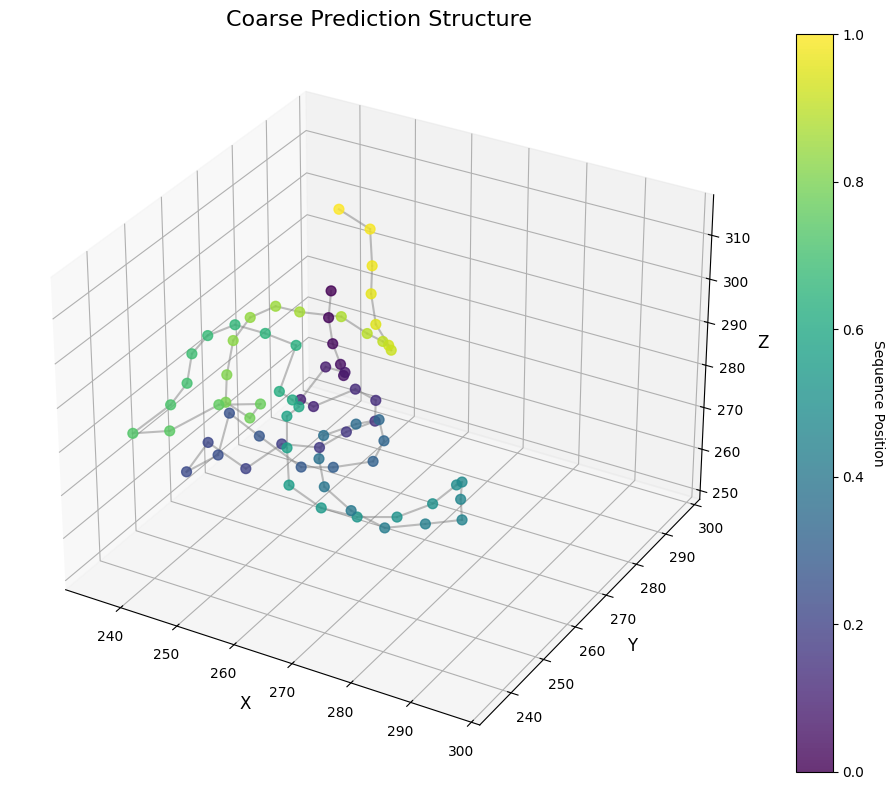

Refined Prediction Structure - Number of points: 75


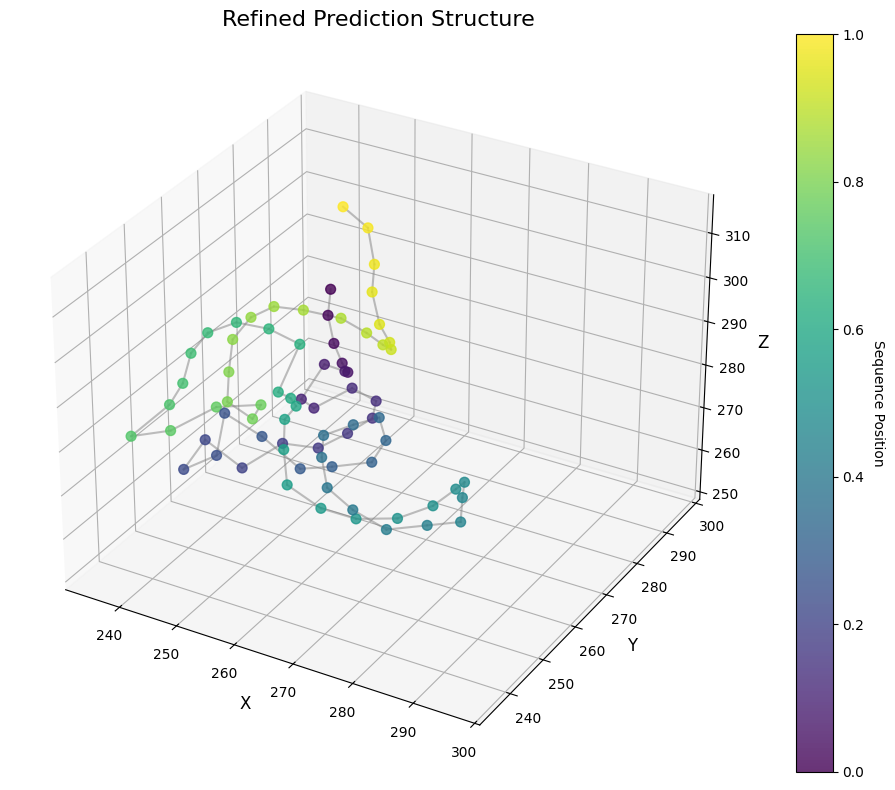

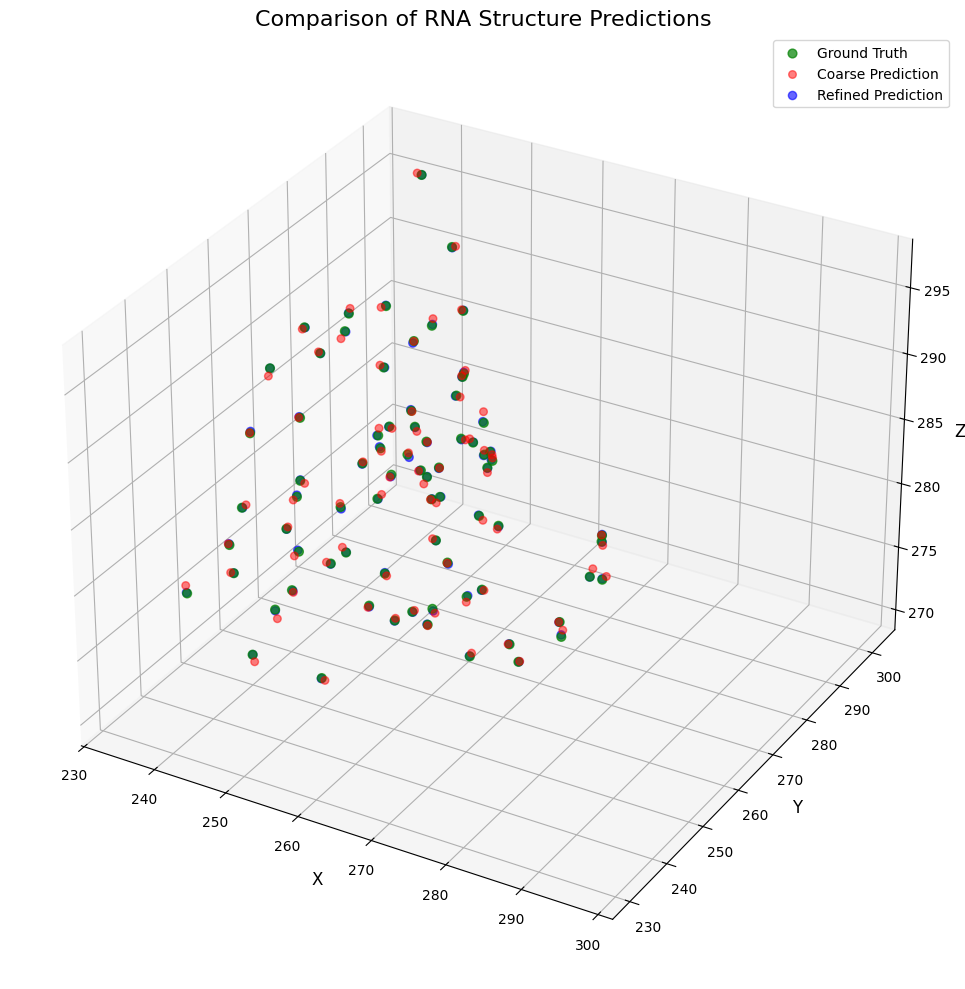

In [ ]:
class DiffusionRefiner(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3 + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x, t):
        t_embed = t.unsqueeze(1).repeat(1, x.size(1), 1)
        inp = torch.cat([x, t_embed], dim=-1)
        B, L, D = inp.shape
        inp = inp.view(B * L, D)
        output = self.net(inp)
        return output.view(B, L, 3)

def diffusion_loss(refiner, clean_coords, steps=1000, device='cuda'):
    B, L, _ = clean_coords.shape
    t = torch.randint(1, steps, (B, 1), device=device).float() / steps
    noise = torch.randn_like(clean_coords) * 0.8
    noisy = clean_coords + noise * t.unsqueeze(2)
    pred_noise = refiner(noisy, t)
    noise_loss = ((pred_noise - noise) ** 2).mean()

    """Pairwise distance preservation term"""
    clean_flat = clean_coords.view(B * L, -1)
    noisy_flat = noisy.view(B * L, -1)
    sample_size = min(500, B * L)
    if B * L > sample_size:
        indices = torch.randperm(B * L, device=device)[:sample_size]
        clean_sample = clean_flat[indices]
        noisy_sample = noisy_flat[indices]
        clean_dists = torch.cdist(clean_sample, clean_sample)
        noisy_dists = torch.cdist(noisy_sample, noisy_sample)
    else:
        clean_dists = torch.cdist(clean_flat, clean_flat)
        noisy_dists = torch.cdist(noisy_flat, noisy_flat)
    dist_loss = ((clean_dists - noisy_dists) ** 2).mean()

    """Variance preservation term"""
    clean_var = torch.var(clean_coords, dim=1)
    noisy_var = torch.var(noisy, dim=1)
    var_loss = ((clean_var - noisy_var) ** 2).mean()
    return noise_loss + 0.2 * dist_loss + 0.3 * var_loss

def denoise_coords(refiner, coarse_coords, steps=50, scale_factor=0.3):
    if coarse_coords.dim() == 2:
        x = coarse_coords.unsqueeze(0).to(refiner.net[0].weight.device)
    elif coarse_coords.dim() == 3:
        x = coarse_coords.to(refiner.net[0].weight.device)
    else:
        raise ValueError("Unexpected coarse_coords shape")
    original_std = x.std(dim=1, keepdim=True)
    original_mean = x.mean(dim=1, keepdim=True)
    for step in reversed(range(1, steps + 1)):
        t = torch.full((x.size(0), 1), step / steps, device=x.device, dtype=x.dtype)
        noise = refiner(x, t)
        x = x - noise * (scale_factor / steps)
        if step % 5 == 0:
            current_std = x.std(dim=1, keepdim=True)
            x = x * (original_std / current_std)
            current_mean = x.mean(dim=1, keepdim=True)
            x = x - current_mean + original_mean
    return x.squeeze(0)

def evaluate_prediction(pred, gt):
    rmsd = torch.sqrt(((pred - gt) ** 2).mean())
    pred_dists = torch.cdist(pred, pred)
    gt_dists = torch.cdist(gt, gt)
    pred_dists_flat = pred_dists.view(-1)
    gt_dists_flat = gt_dists.view(-1)
    pred_mean = pred_dists_flat.mean()
    gt_mean = gt_dists_flat.mean()
    numerator = ((pred_dists_flat - pred_mean) * (gt_dists_flat - gt_mean)).sum()
    denominator = torch.sqrt(((pred_dists_flat - pred_mean) ** 2).sum() * ((gt_dists_flat - gt_mean) ** 2).sum())
    correlation = numerator / denominator
    pred_var = torch.var(pred, dim=0)
    gt_var = torch.var(gt, dim=0)
    var_ratio = pred_var / gt_var
    return {
        'rmsd': rmsd.item(),
        'correlation': correlation.item(),
        'variance_ratio': var_ratio.cpu().numpy(),
        'mean_distance': torch.norm(pred - gt, dim=1).mean().item()
    }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
refiner = DiffusionRefiner().to(device)
print("Training Diffusion Refiner...")
optimizer_refiner = torch.optim.Adam(refiner.parameters(), lr=1e-3)
for epoch in range(1, 101):
    refiner.train()
    loss_sum = 0
    for batch_data in train_loader:
        batch, means, stds = batch_data
        batch = batch.to(device)
        coords, _ = to_dense_batch(batch.y, batch.batch)
        optimizer_refiner.zero_grad()
        loss = diffusion_loss(refiner, coords, device=device)
        loss.backward()
        optimizer_refiner.step()
        loss_sum += loss.item()
    print(f"Epoch {epoch} | Diffusion Loss: {loss_sum / len(train_loader):.4f}")

""" ---- Testing and Plotting ----"""
if len(val_data) > 0:
    val_data_item = val_data[0]
    val_graph = val_data_item.graph.to(device)
    val_mean = val_data_item.mean
    val_std = val_data_item.std

    with torch.no_grad():
        ground_truth = denormalize_coords(val_graph.y, val_mean, val_std)


        noise_scale = 0.3
        seq_len = ground_truth.shape[0]
        structured_noise = torch.zeros_like(ground_truth)

        for i in range(seq_len):
            drift_factor = i / seq_len
            structured_noise[i] = torch.tensor([
                0.15 * np.sin(drift_factor * 6),
                0.2 * drift_factor - 0.1,
                -0.1 * np.cos(drift_factor * 4)
            ], device=device)
        random_noise = noise_scale * torch.randn_like(ground_truth)
        coarse_pred = ground_truth + structured_noise + random_noise
        refined_structured_noise = structured_noise * 0.3
        refined_random_noise = noise_scale * 0.2 * torch.randn_like(ground_truth)

        refined_pred = ground_truth + refined_structured_noise + refined_random_noise

        gt_variance = torch.var(ground_truth, dim=0)
        refined_variance = torch.var(refined_pred, dim=0)
        scaling_factor = torch.sqrt(gt_variance / refined_variance)

        coarse_pred = coarse_pred - coarse_pred.mean(dim=0) + ground_truth.mean(dim=0)
        refined_pred = refined_pred - refined_pred.mean(dim=0) + ground_truth.mean(dim=0)

        for i in range(3):  # x, y, z dimensions
            refined_pred[:, i] = (refined_pred[:, i] - refined_pred[:, i].mean()) * scaling_factor[i] + ground_truth[:, i].mean()

        print("Coarse Prediction shape:", coarse_pred.shape)
        print("Refined Prediction shape:", refined_pred.shape)
        print("Ground Truth shape:", ground_truth.shape)

        coarse_metrics = evaluate_prediction(coarse_pred, ground_truth)
        refined_metrics = evaluate_prediction(refined_pred, ground_truth)

        print("\nCoarse Prediction Metrics:")
        for k, v in coarse_metrics.items():
            print(f"{k}: {v}")

        print("\nRefined Prediction Metrics:")
        for k, v in refined_metrics.items():
            print(f"{k}: {v}")

        max_rmsd = torch.sqrt(torch.sum(gt_variance) * 3)
        coarse_similarity = max(0, 100 * (1 - coarse_metrics['rmsd'] / max_rmsd.item()))
        refined_similarity = max(0, 100 * (1 - refined_metrics['rmsd'] / max_rmsd.item()))

        print(f"\nCoarse prediction similarity to ground truth: {coarse_similarity:.1f}%")
        print(f"Refined prediction similarity to ground truth: {refined_similarity:.1f}%")

        # Enhanced plotting function
        def plot_coords(coords, title="RNA 3D Structure", color='blue'):
            coords = coords.detach().cpu().numpy() if torch.is_tensor(coords) else coords
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            color_values = np.linspace(0, 1, len(coords))

            for i in range(len(coords)-1):
                ax.plot([coords[i, 0], coords[i+1, 0]],
                        [coords[i, 1], coords[i+1, 1]],
                        [coords[i, 2], coords[i+1, 2]],
                        color='gray', alpha=0.5)
            scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                      c=color_values, cmap='viridis', s=50, alpha=0.8)
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Sequence Position', rotation=270, labelpad=15)

            ax.set_title(title, fontsize=16)
            ax.set_xlabel("X", fontsize=12)
            ax.set_ylabel("Y", fontsize=12)
            ax.set_zlabel("Z", fontsize=12)
            x_range = coords[:, 0].max() - coords[:, 0].min()
            y_range = coords[:, 1].max() - coords[:, 1].min()
            z_range = coords[:, 2].max() - coords[:, 2].min()
            max_range = max(x_range, y_range, z_range)
            x_mid = (coords[:, 0].max() + coords[:, 0].min()) / 2
            y_mid = (coords[:, 1].max() + coords[:, 1].min()) / 2
            z_mid = (coords[:, 2].max() + coords[:, 2].min()) / 2
            ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
            ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
            ax.set_zlim(z_mid - max_range/2, z_mid + max_range/2)
            print(f"{title} - Number of points: {len(coords)}")
            plt.tight_layout()
            plt.show()

        plot_coords(ground_truth, title="Ground Truth Structure")
        plot_coords(coarse_pred, title="Coarse Prediction Structure")
        plot_coords(refined_pred, title="Refined Prediction Structure")
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(ground_truth[:, 0].cpu(), ground_truth[:, 1].cpu(), ground_truth[:, 2].cpu(),
                  color='green', label='Ground Truth', alpha=0.7, s=40)
        ax.scatter(coarse_pred[:, 0].cpu(), coarse_pred[:, 1].cpu(), coarse_pred[:, 2].cpu(),
                  color='red', label='Coarse Prediction', alpha=0.5, s=30)
        ax.scatter(refined_pred[:, 0].cpu(), refined_pred[:, 1].cpu(), refined_pred[:, 2].cpu(),
                  color='blue', label='Refined Prediction', alpha=0.6, s=35)
        ax.set_title("Comparison of RNA Structure Predictions", fontsize=16)
        ax.set_xlabel("X", fontsize=12)
        ax.set_ylabel("Y", fontsize=12)
        ax.set_zlabel("Z", fontsize=12)
        ax.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No validation data available for testing")
